# Counterfactual explanations

In [1]:
import trustyai

trustyai.init()

## Simple example

We start by defining our black-box model, typically represented by

$$
f(\mathbf{x}) = \mathbf{y}
$$

Where $\mathbf{x}=\{x_1, x_2, \dots,x_m\}$ and $\mathbf{y}=\{y_1, y_2, \dots,y_n\}$.

Our example toy model, in this case, takes an all-numerical input $\mathbf{x}$ and return a $\mathbf{y}$ of either `true` or `false` if the sum of the $\mathbf{x}$ components is within a threshold $\epsilon$ of a point $\mathbf{C}$, that is:

$$
f(\mathbf{x}, \epsilon, \mathbf{C})=\begin{cases}
\text{true},\qquad \text{if}\ \mathbf{C}-\epsilon<\sum_{i=1}^m x_i <\mathbf{C}+\epsilon \\
\text{false},\qquad \text{otherwise}
\end{cases}
$$

This model is provided in the `TestUtils` module. We instantiate with a $\mathbf{C}=500$ and $\epsilon=1.0$.

In [2]:
from trustyai.utils import TestUtils

center = 500.0
epsilon = 1.0

model = TestUtils.getSumThresholdModel(center, epsilon)

Next we need to define a **goal**.
If our model is $f(\mathbf{x'})=\mathbf{y'}$ we are then defining our $\mathbf{y'}$ and the counterfactual result will be the $\mathbf{x'}$ which satisfies $f(\mathbf{x'})=\mathbf{y'}$.

We will define our goal as `true`, that is, the sum is withing the vicinity of a (to be defined) point $\mathbf{C}$. The goal is a list of `Output` which take the following parameters

- The feature name
- The feature type
- The feature value (wrapped in `Value`)
- A confidence threshold, which we will leave at zero (no threshold)

In [3]:
from trustyai.model import output

goal = [output(name="inside", dtype="bool", value=True)]

We will now define our initial features, $\mathbf{x}$. Each feature can be instantiated by using `FeatureFactory` and in this case we want to use numerical features, so we'll use `FeatureFactory.newNumericalFeature`.

In [4]:
import random
from trustyai.model import feature

features = [
    feature(name=f"x{i+1}", value=random.random() * 10.0, dtype="number")
    for i in range(4)
]

As we can see, the sum of of the features will not be within $\epsilon$ (1.0) of $\mathbf{C}$ (500.0). As such the model prediction will be `false`:

In [5]:
feature_sum = 0.0
for f in features:
    value = f.value.as_number()
    print(f"Feature {f.name} has value {value}")
    feature_sum += value
print(f"\nFeatures sum is {feature_sum}")

Feature x1 has value 8.383112183880774
Feature x2 has value 1.5296907450266672
Feature x3 has value 6.324409811461678
Feature x4 has value 3.0125007391588077

Features sum is 19.249713479527923


The next step is to specify the **constraints** of the features, i.e. which features can be changed and which should be fixed. Since we want all features to be able to change, we specify `False` for all of them:

In [6]:
constraints = [False] * 4

Finally, we also specify which are the **bounds** for the counterfactual search. Typically this can be set either using domain-specific knowledge or taken from the data. In this case we simply specify an arbitrary (sensible) value, e.g. all the features can vary between `0` and `1000`.

In [7]:
feature_boundaries = [(0.0, 1000.0)] * 4

We can now instantiate the **explainer** itself.

To do so, we will to configure the termination criteria. For this example we will specify that the counterfactual search should only execute a maximum of 10,000 iterations before stopping and returning whatever the best result is so far.

We can can now instantiate the explainer itself using `CounterfactualExplainer`.

In [8]:
from trustyai.explainers import CounterfactualExplainer

explainer = CounterfactualExplainer(steps=10_000)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


We will now express the counterfactual problem as defined above.

- `input` represents our $\mathbf{x}$ which know gives a prediction of `False`
- `outputs` represents our $\mathbf{y'}$, that is our desired prediction (`True`)
- `domain` repreents the boundaries for the counterfactual search

We wrap these quantities in a `CounterfactualPrediction` (the UUID is simply to label the search instance):

In [9]:
from trustyai.model import counterfactual_prediction

prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal,
    domains=feature_boundaries)

We now request the counterfactual $\mathbf{x'}$ which is closest to $\mathbf{x}$ and which satisfies $f(\mathbf{x'}, \epsilon, \mathbf{C})=\mathbf{y'}$:

In [10]:
explanation = explainer.explain(prediction, model)

We can see that the counterfactual $\mathbf{x'}$

In [11]:
feature_sum = 0.0
for entity in explanation.entities:
    print(entity)
    feature_sum += entity.getProposedValue()

print(f"\nFeature sum is {feature_sum}")

java.lang.DoubleEntity{value=8.383112183880774, rangeMinimum=0.0, rangeMaximum=1000.0, id='x1'}
java.lang.DoubleEntity{value=481.32000081209515, rangeMinimum=0.0, rangeMaximum=1000.0, id='x2'}
java.lang.DoubleEntity{value=6.495107736558037, rangeMinimum=0.0, rangeMaximum=1000.0, id='x3'}
java.lang.DoubleEntity{value=3.0125007391588077, rangeMinimum=0.0, rangeMaximum=1000.0, id='x4'}

Feature sum is 499.21072147169275


### Constrained features

As we've seen, it is possible to constraint a specific feature $x_i$ by setting the _constraints_ list corresponding element to `True`.

In this example, we know want to fix $x_1$ and $x_4$. That is, these features should have the same value in the counterfactual $\mathbf{x'}$ as in the original $\mathbf{x}$.

In [12]:
constraints = [True, False, False, True]  # x1, x2, x3 and x4

We simply need to wrap the previous quantities with the new constraints:

In [13]:
prediction = counterfactual_prediction(
    input_features=features, 
    outputs=goal, 
    domains=feature_boundaries, 
    constraints=constraints)

And request a new counterfactual explanation

In [14]:
explanation = explainer.explain(prediction, model)

We can see that $x_1$ and $x_4$ has the same value as the original and the model satisfies the conditions.

In [15]:
print(f"Original x1: {features[0].value.as_number()}")
print(f"Original x4: {features[3].value.as_number()}\n")

for entity in explanation.entities:
    print(entity)

Original x1: 8.383112183880774
Original x4: 3.0125007391588077

java.lang.DoubleEntity{value=8.383112183880774, rangeMinimum=8.383112183880774, rangeMaximum=8.383112183880774, id='x1'}
java.lang.DoubleEntity{value=481.32000081209515, rangeMinimum=0.0, rangeMaximum=1000.0, id='x2'}
java.lang.DoubleEntity{value=6.495107736558037, rangeMinimum=0.0, rangeMaximum=1000.0, id='x3'}
java.lang.DoubleEntity{value=3.0125007391588077, rangeMinimum=3.0125007391588077, rangeMaximum=3.0125007391588077, id='x4'}


## Using Python models



We will now show how to use a custom Python model with TrustyAI counterfactual explanations.

The model will be an [XGBoost](https://github.com/dmlc/xgboost) one trained with the `credit-bias` dataset (available [here](https://github.com/ruivieira/benchmark-models/tree/main/credit-bias)).

For convenience, the model is pre-trained and serialised with `joblib` so that for this example we simply need to deserialised it.

In [16]:
import joblib

xg_model = joblib.load("models/credit-bias-xgboost.joblib")
print(xg_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.07, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9861206227457426,
              seed=27, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)


This model has as a single **output** a boolean `PaidLoan`, which will predict whether a certain loan applicant will repay the loan in time or not. The model is slightly more complex than the previous examples, with **input** features:

|Input feature         | Type    | Note        |
|----------------------|---------|-------------|
|`NewCreditCustomer`   |boolean  ||
|`Amount`              |numerical||
|`Interest`            |numerical||
|`LoanDuration`        |numerical|In months|
|`Education`           |numerical|Level (1, 2, 3..)|
|`NrOfDependants`      |numerical|Integer|
|`EmploymentDurationCurrentEmployer`|numerical|Integer (years)|
|`IncomeFromPrincipalEmployer`|numerical||
|`IncomeFromPension`   |numerical||
|`IncomeFromFamilyAllowance`|numerical||
|`IncomeFromSocialWelfare`|numerical||
|`IncomeFromLeavePay`|numerical||
|`IncomeFromChildSupport`|numerical||
|`IncomeOther`|numerical||
|`ExistingLiabilities`|numerical|integer|
|`RefinanceLiabilities`|numerical|integer|
|`DebtToIncome`|numerical||
|`FreeCash`|numerical||
|`CreditScoreEeMini`|numerical|integer|
|`NoOfPreviousLoansBeforeLoan`|numerical|integer|
|`AmountOfPreviousLoansBeforeLoan`|numerical||
|`PreviousRepaymentsBeforeLoan`|numerical||
|`PreviousEarlyRepaymentsBefoleLoan`|numerical||
|`PreviousEarlyRepaymentsCountBeforeLoan`|numerical|integer|
|`Council_house`|boolean||
|`Homeless`|boolean||
|`Joint_ownership`|boolean||
|`Joint_tenant`|boolean||
|`Living_with_parents`|boolean||
|`Mortgage`|boolean||
|`Other`|boolean||
|`Owner`|boolean||
|`Owner_with_encumbrance`|boolean||
|`Tenant`|boolean||
|`Entrepreneur`|boolean||
|`Fully`|boolean||
|`Partially`|boolean||
|`Retiree`|boolean||
|`Self_employed`|boolean||

We will start by testing the model with an input we are quite sure (from the original data) that will be predicted as `false`:

In [17]:
x = [
    [
        False,
        2125.0,
        20.97,
        60,
        4.0,
        0.0,
        6.0,
        0.0,
        301.0,
        0.0,
        53.0,
        0.0,
        0.0,
        0.0,
        8,
        6,
        26.29,
        10.92,
        1000.0,
        1.0,
        500.0,
        590.95,
        0.0,
        0.0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        1,
        0,
        0,
        0,
        0,
        0,
        1,
        0,
    ]
]

We can see that this application will be rejected with a probability of $\sim77\%$:

In [18]:
import numpy as np

print(xg_model.predict_proba(np.array(x)))
print(f"Paid loan is predicted as: {xg_model.predict(np.array(x))}")

[[0.7770493  0.22295067]]
Paid loan is predicted as: [False]


We will now prepare the XGBoost model to be used from the TrustyAI counterfactual engine.

To do so, we simply need to first create a prediction function which takes:

- A list of `PredictionInput` as inputs
- A list of `PredictionOutput` as outputs

If these two conditions are met, the actual inner working of this method can be anything (including calling a XGBoost Python model for prediction as in our case):

In [19]:
from org.kie.kogito.explainability.model import PredictionInput, PredictionOutput

def predict(inputs):
    values = [_feature.value.as_obj() for _feature in inputs[0].features]
    result = xg_model.predict_proba(np.array([values]))
    false_prob, true_prob = result[0]
    if false_prob > true_prob:
        _prediction = (False, false_prob)
    else:
        _prediction = (True, true_prob)
    _output = output(name="PaidLoan", dtype="bool", value=_prediction[0], score=_prediction[1])
    return [PredictionOutput([_output])]

Once the prediction method is created, we wrap in a `PredictionProvider` class.

This class takes care of all the JVM's asynchronous plumbing for us.

In [20]:
from trustyai.model import Model

model = Model(predict)

We will now express the previous inputs (`x`) in terms of `Feature`s, so that we might use it for the counterfactual search:

In [21]:
def make_feature(name, value):
    if isinstance(value, bool):
        return feature(name=name, dtype="bool", value=value)
    else:
        return feature(name=name, dtype="number", value=value)


features = [
    make_feature(p[0], p[1])
    for p in [
        ("NewCreditCustomer", False),
        ("Amount", 2125.0),
        ("Interest", 20.97),
        ("LoanDuration", 60.0),
        ("Education", 4.0),
        ("NrOfDependants", 0.0),
        ("EmploymentDurationCurrentEmployer", 6.0),
        ("IncomeFromPrincipalEmployer", 0.0),
        ("IncomeFromPension", 301.0),
        ("IncomeFromFamilyAllowance", 0.0),
        ("IncomeFromSocialWelfare", 53.0),
        ("IncomeFromLeavePay", 0.0),
        ("IncomeFromChildSupport", 0.0),
        ("IncomeOther", 0.0),
        ("ExistingLiabilities", 8.0),
        ("RefinanceLiabilities", 6.0),
        ("DebtToIncome", 26.29),
        ("FreeCash", 10.92),
        ("CreditScoreEeMini", 1000.0),
        ("NoOfPreviousLoansBeforeLoan", 1.0),
        ("AmountOfPreviousLoansBeforeLoan", 500.0),
        ("PreviousRepaymentsBeforeLoan", 590.95),
        ("PreviousEarlyRepaymentsBefoleLoan", 0.0),
        ("PreviousEarlyRepaymentsCountBeforeLoan", 0.0),
        ("Council_house", False),
        ("Homeless", False),
        ("Joint_ownership", False),
        ("Joint_tenant", False),
        ("Living_with_parents", False),
        ("Mortgage", False),
        ("Other", False),
        ("Owner", False),
        ("Owner_with_encumbrance", True),
        ("Tenant", True),
        ("Entrepreneur", False),
        ("Fully", False),
        ("Partially", False),
        ("Retiree", True),
        ("Self_employed", False),
    ]
]

We can confirm now, with the newly created `PredictionProvider` model that this input will lead to a `false` `PaidLoan` prediction:

In [22]:
model.predictAsync([PredictionInput(features)]).get()[0].outputs[0].toString()

'Output{value=false, type=boolean, score=0.7835956811904907, name='PaidLoan'}'

### Unconstraind basic search

To get started we will search for a counterfactual with no constraints at all. This is not a realistic use case, but we will use it as a baseline.

We will also create a set of equal bounds for all the features. Again, this is not realistic, but we do it to establish a baseline. Note that boolean features will ignore the bounds anyway, so we can just create a set such as:

In [23]:
n_features = len(features)

domains = [(0.0, 10000.0)] * n_features

We want our **goal** to be the model predicting the loan will be paid (`PaidLoad=true`), so we specify it as:

In [24]:
goal = [output(name="PaidLoan", dtype="bool", value=True)]

We now wrap all this context in a `CounterfactualPrediction` object

In [25]:
prediction = counterfactual_prediction(
    input_features=features, 
    outputs=goal, 
    domains=domains)

We are now ready to search for a counterfactual:

In [26]:
explanation = explainer.explain(prediction, model)

First we will confirm that our counterfactual changes the outcome, by predicting its outcome using the model:

In [27]:
testf = [f.asFeature() for f in explanation.getEntities()]
model.predictAsync([PredictionInput(testf)]).get()[0].getOutputs()[
    0
].toString()

'Output{value=true, type=boolean, score=0.5882376432418823, name='PaidLoan'}'

And indeed it changes. We will now verify _which_ features were changed:

In [28]:
def show_changes(explanation, original):
    entities = explanation.entities
    N = len(original)
    for i in range(N):
        name = original[i].name
        original_value = original[i].value.as_number()
        new_value = entities[i].as_feature().value.as_number()
        if original_value != new_value:
            print(f"Feature '{name}': {original_value} -> {new_value}")


show_changes(explanation, features)

Feature 'RefinanceLiabilities': 6.0 -> 1.230474777192958
Feature 'PreviousEarlyRepaymentsCountBeforeLoan': 0.0 -> 6.0


Here we can see the problem with the unconstrained search.

Some of the fields that were changed (_e.g._ `IncomeFromSocialWelfare`, `RefinanceLiabilities`, etc) might be difficult to change in practice.

### Constrained search

We will now try a more realistic search, which incorporates domain specific knowledge (and common sence).

To do so, we will constrain features we feel they shouldn't (or mustn't) change and specify sensible search bounds.
We will start with the constraints:

In [29]:
constraints = [
    True,  # NewCreditCustomer
    False,  # Amount
    True,  # Interest
    False,  # LoanDuration
    True,  # Education
    True,  # NrOfDependants
    False,  # EmploymentDurationCurrentEmployer
    False,  # IncomeFromPrincipalEmployer
    False,  # IncomeFromPension
    False,  # IncomeFromFamilyAllowance
    False,  # IncomeFromSocialWelfare
    False,  # IncomeFromLeavePay
    False,  # IncomeFromChildSupport
    False,  # IncomeOther
    True,  # ExistingLiabilities
    True,  # RefinanceLiabilities
    False,  # DebtToIncome
    False,  # FreeCash
    False,  # CreditScoreEeMini
    True,  # NoOfPreviousLoansBeforeLoan
    True,  # AmountOfPreviousLoansBeforeLoan
    True,  # PreviousRepaymentsBeforeLoan
    True,  # PreviousEarlyRepaymentsBefoleLoan
    True,  # PreviousEarlyRepaymentsCountBeforeLoan
    False,  # Council_house
    False,  # Homeless
    False,  # Joint_ownership
    False,  # Joint_tenant
    False,  # Living_with_parents
    False,  # Mortgage
    False,  # Other
    False,  # Owner
    False,  # Owner_with_encumbrance"
    False,  # Tenant
    False,  # Entrepreneur
    False,  # Fully
    False,  # Partially
    False,  # Retiree
    False,  # Self_employed
]

The constraints should be self-explanatory, but in essence they were divided into three groups

- Attributes you **cannot** or **should** not change (protected), for instance age, education level, etc
- Attributes you **can** change, for loan duration, loan amount, etc
- Attributes you probably won't be able to change, but might be informative to change. For instance, you might not be able to easily change your income, but you might be interested in how much would it need to be in order to get the prediction as favourable.

In [30]:
features_boundaries = [
    None,  # NewCreditCustomer
    (0.0, 1000.0),  # Amount
    None,  # Interest
    (0.0, 120.0),  # LoanDuration
    None,  # Education
    None,  # NrOfDependants
    (0.0, 40.0),  # EmploymentDurationCurrentEmployer
    (0.0, 1000.0),  # IncomeFromPrincipalEmployer
    (0.0, 1000.0),  # IncomeFromPension
    (0.0, 1000.0),  # IncomeFromFamilyAllowance
    (0.0, 1000.0),  # IncomeFromSocialWelfare
    (0.0, 1000.0),  # IncomeFromLeavePay
    (0.0, 1000.0),  # IncomeFromChildSupport
    (0.0, 1000.0),  # IncomeOthe
    None,  # ExistingLiabilities
    None,  # RefinanceLiabilities
    (0.0, 100.0),  # DebtToIncome
    (0.0, 100.0),  # FreeCash
    (0.0, 10000.0),  # CreditScoreEeMini
    None,  # NoOfPreviousLoansBeforeLoan
    None,  # AmountOfPreviousLoansBeforeLoan
    None,  # PreviousRepaymentsBeforeLoan
    None,  # PreviousEarlyRepaymentsBefoleLoan
    None,  # PreviousEarlyRepaymentsCountBeforeLoan
    None,  # Council_house
    None,  # Homeless
    None,  # Joint_ownership
    None,  # Joint_tenant
    None,  # Living_with_parents
    None,  # Mortgage
    None,  # Other
    None,  # Owner
    None,  # Owner_with_encumbrance
    None,  # Tenant
    None,  # Entrepreneur
    None,  # Fully
    None,  # Partially
    None,  # Retiree
    None,  # Self_employed
]

As before, we wrap this data in a `CounterfactualPrediction`:

In [31]:
prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal,
    domains=features_boundaries,
    constraints=constraints
)

And we start a new search:

In [32]:
explanation = explainer.explain(prediction, model)

We test that the counterfactual does change the outcome:

In [33]:
testf = [f.as_feature() for f in explanation.entities]
model.predictAsync([PredictionInput(testf)]).get()[0].outputs[0].toString()

'Output{value=true, type=boolean, score=0.5038489103317261, name='PaidLoan'}'

And we confirm that no constrained features were changed:

In [34]:
show_changes(explanation, features)

Feature 'LoanDuration': 60.0 -> 56.432745812537775
Feature 'IncomeFromSocialWelfare': 53.0 -> 60.0


### Minimum counterfactual probabilities

We can see that the previous answer is very close to $50\%$.

With TrustyAI we have the possiblity to specify a minimum probability for the result (when the model supports prediction confidences).

Let's say we want a result that is at least $75\%$ confident that the loan will be repaid. We can just encode the **minimum probability** as the last argument of each `Output`. A minimum probability of $0$ (as we've used) simply means that any desired outcome will be accepted, regardless of its probability. 

In [35]:
goal = [output(name="PaidLoan", dtype="bool", value=True, score=0.75)]

We can then re-run the search with all the data as defined previously:

In [36]:
prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal,
    domains=features_boundaries,
    constraints=constraints
)

In [37]:
explanation = explainer.explain(prediction, model)

As previously, we check that the answer is what we are looking for

In [38]:
testf = [f.as_feature() for f in explanation.entities]
model.predictAsync([PredictionInput(testf)]).get()[0].outputs[0].toString()

'Output{value=true, type=boolean, score=0.7572674751281738, name='PaidLoan'}'

And we show which features need to be changed for said desired outcome:

In [39]:
show_changes(explanation, features)

Feature 'LoanDuration': 60.0 -> 14.798944010723588


## Visualisation

Let's try to visualise counterfactuals in action with the following example:

We construct three clusters of data and train a model to assign points to a cluster.
Our counterfactual question can then be

> If we have a point $X$ belonging to a certain cluster $C$, how far would it need to move
> in order to belong to a desired cluster $C^'$

In [40]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=2000, n_features=2, random_state=0, centers=[(-5,0), (0, 5), (5, 0)])

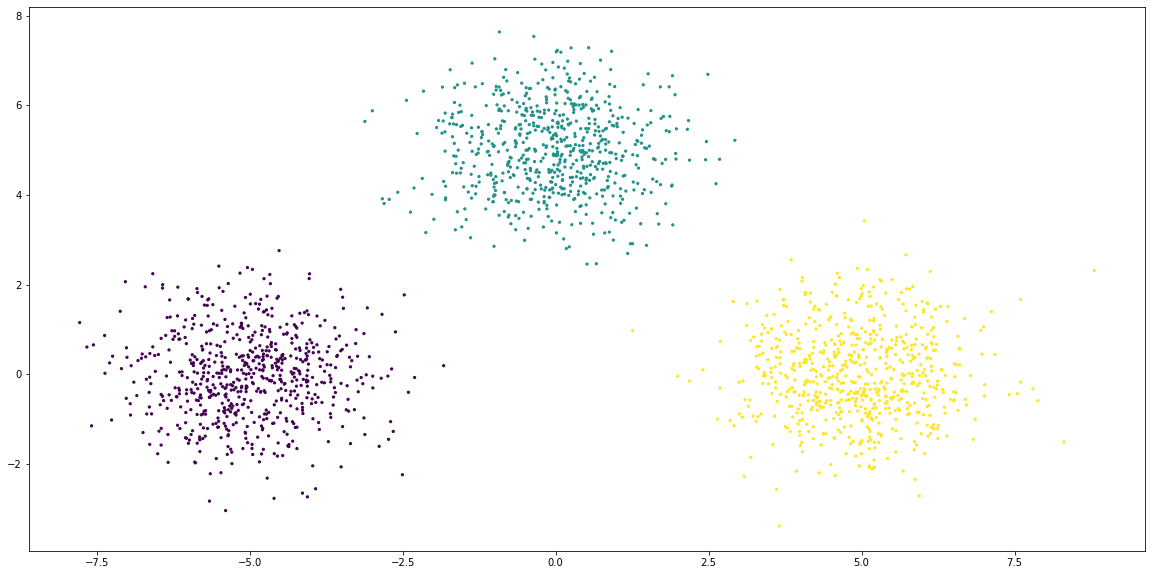

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=y, s=5)
plt.show()

We now train a KNN model in order to classify points and assign them to a cluster.

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=3)

If we take a point such as `(2.5, -1)` it is clear this point will belong to cluster `2`.

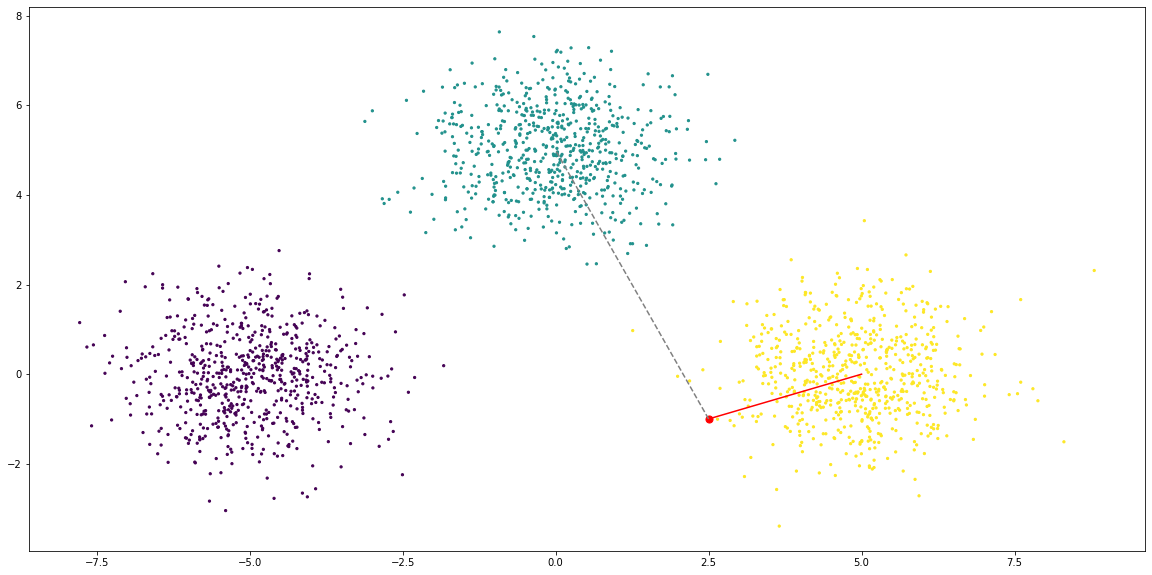

In [43]:
plt.figure(figsize=(20,10))
ORIGINAL = [2.5, -1.0]
plt.scatter(X[:,0], X[:,1], c=y, s=5)
plt.scatter(ORIGINAL[0], ORIGINAL[1], c="red", s=50)
plt.plot([ORIGINAL[0], 5], [ORIGINAL[1], 0], c="red")
plt.plot([ORIGINAL[0], 0], [ORIGINAL[1], 5], c="grey", linestyle="dashed")
plt.show()

In [44]:
import numpy as np

knn.predict_proba(np.array([[2.5, -1.0]]))

array([[0., 0., 1.]])

We can now create our prediction function. I will simply take the `x` and `y` and return the cluster classification,
along with a probability.

In [45]:
def knn_classify(inputs):
    values = [_feature.value.as_number() for _feature in inputs[0].features]
    result = knn.predict_proba(np.array([values]))
    index = np.argmax(result, axis=1)[0]
    _output = output(name="cluster", dtype="number", value=index, score=result[0][index])
    return [PredictionOutput([_output])]

We wrap this function in the `Model` wrapper.

In [46]:
from trustyai.model import Model

knn_model = Model(knn_classify)

We can test it and confirm it works as expected.

In [47]:
features = [feature("x", "number", 2.5), feature("y", "number", -1.0)]
knn_model.predictAsync([PredictionInput(features)]).get()[0].outputs[0].toString()

'Output{value=2, type=number, score=1.0, name='cluster'}'

We now define our goal. We want it to belong to cluster `1`.

In [48]:
goal = [output(name="cluster", dtype="number", value=1)]

We pass this data to the explainer along with the search boundaries.

In [49]:
prediction = counterfactual_prediction(
    input_features=features,
    outputs=goal,
    domains=[(-10, 10), (-10, 10)]
)
explanation = explainer.explain(prediction, knn_model)

The counterfactual we get is:

In [50]:
result = [f.as_feature().value.as_number() for f in explanation.entities]
result

[2.501921601686025, 2.6401536249215436]

We can confirm this point belongs to cluster `1`

In [51]:
testf = [feature("x", "number", result[0]), feature("y", "number", result[1])]
knn_model.predictAsync([PredictionInput(testf)]).get()[0].outputs[0].toString()

'Output{value=1, type=number, score=1.0, name='cluster'}'

And visually:

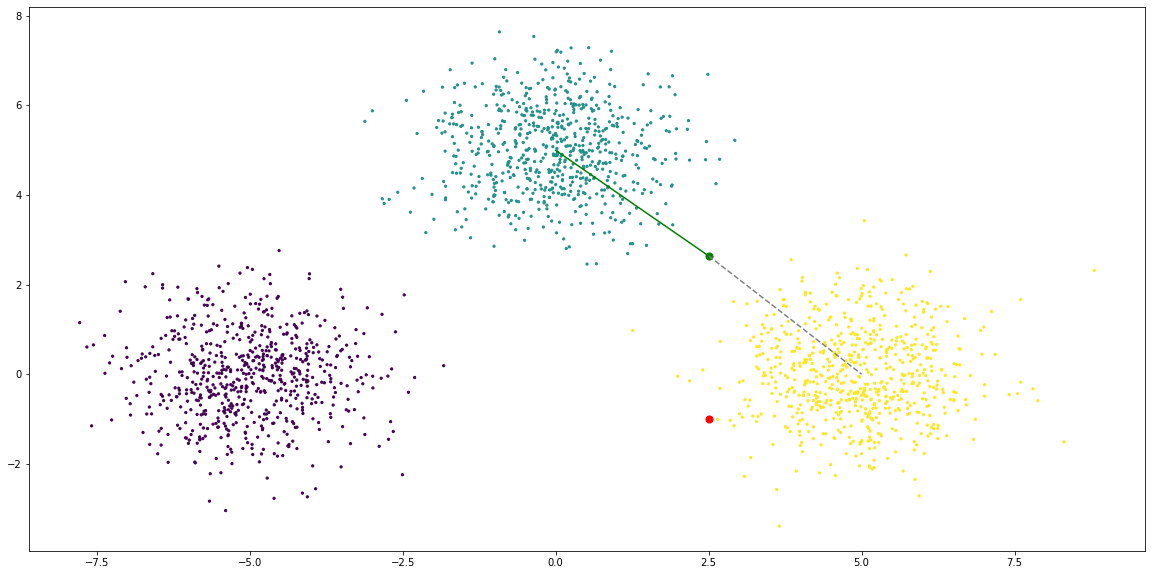

In [52]:
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], c=y, s=5)
plt.scatter(ORIGINAL[0], ORIGINAL[1], c="red", s=50)
plt.scatter(result[0], result[1], c="green", s=50)
plt.plot([result[0], 5], [result[1], 0], c="grey", linestyle="dashed")
plt.plot([result[0], 0], [result[1], 5], c="green")

plt.show()